In [1]:
import numpy as np
import torch, torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as ds
import torch.nn as nn

from bgan.networkparts import layer13
import bgan.augLayers as augLayers
from bgan.datasets import CIFAR10
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
img_size = 32
transform_train = transforms.Compose(
    [transforms.Resize(img_size),
    transforms.ToTensor()])
pathToDataset = '/scratch/datasets/cifar10/'
trainset = ds.CIFAR10(pathToDataset, download=True, transform=transform_train)

Files already downloaded and verified


In [10]:
# XX_sum = 0
# X_sum = 0
# n = 0
# for (img, _) in trainset:
#     x = img.numpy().reshape(-1)
#     X_sum += x
#     XX_sum += np.outer(x,x)
#     n += 1
# X_mean = X_sum/n
# cov = (1/(n-1))*XX_sum - (n/(n-1))*np.outer(X_mean,X_mean)
#trainset.train_data.std((0,1,2))/256

In [11]:
X = trainset.train_data.reshape(-1,32*32*3)
cov = np.cov(X, rowvar=False)

In [12]:
def zca_whitening_matrix(cov):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  cov: [M x M] covariance matrix.
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(cov)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-6
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

In [13]:
ZCAmat = zca_whitening_matrix(cov)

In [14]:
X_white = np.dot(X,ZCAmat.T)

In [15]:
Xr = X_white.reshape(-1,32,32,3)

In [16]:
print(Xr.mean((0,1,2)))
print(Xr.std((0,1,2)))

[0.09044822 0.08679136 0.0467678 ]
[1.00097689 1.00027675 1.0005838 ]


In [25]:
torch.save(ZCAmat.T,"ZCAtrans_np")#print(Xr[:32].shape)

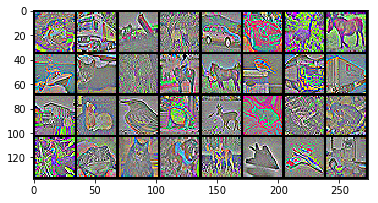

In [21]:
grid = vutils.make_grid(torch.from_numpy(Xr[:32].transpose((0,3,1,2))),normalize=True,range=(-1.5,1.5))
show(grid)
plt.show()

In [22]:
LT = torch.from_numpy(ZCAmat.T)

In [24]:
LT.numpy().shape

(3072, 3072)

In [ ]:
#torch.save(LT,"ZCAtranspose")

In [2]:
datasets = CIFAR10(ZCA=True)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torch.optim as optim
from bgan.cnnTrainer import CnnTrainer
from bgan.datasets import CIFAR10
from bgan.networkparts import layer13
from bgan.schedules import cosLr, sigmoidConsRamp
from bgan.utils import to_var_gpu

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [6]:
savedir = '/home/maf388/tb-experiments/testing00/'
load_path = None#'/home/maf388/tb-experiments/rejectCnnFull/checkpoints/c.999.ckpt'
total_epochs = 100
opt_constr = lambda params, base_lr: optim.SGD(params, base_lr, .9, weight_decay=1e-4, nesterov=True)
lr_lambda = cosLr(total_epochs, 1)

config = {'base_lr':.1, 'amntLab':1, 
          'lab_BS':50, 'ul_BS':50, 'num_workers':0,
          'lr_lambda':lr_lambda, 'opt_constr':opt_constr,
          }

CNN = layer13(numClasses=10)
trainer = CnnTrainer(CNN, datasets, savedir, load_path, **config)

In [9]:
%timeit X,y = to_var_gpu(next(trainer.train_iter))

In [10]:
grid = vutils.make_grid(X.cpu().data,normalize=True,range=(-1.5,1.5))

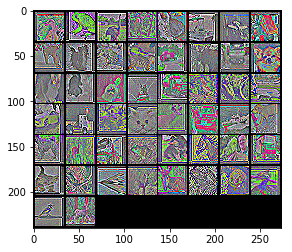

In [11]:
show(grid)
plt.show()

In [12]:
datasets2 = CIFAR10(ZCA=False)
trainer2 = CnnTrainer(CNN, datasets2, savedir, load_path, **config)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
%timeit X,y = to_var_gpu(next(trainer.train_iter))

31.9 ms ± 8.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
